**Кулешов Иван AML-14**

Большая часть содержимого ноутбука выдана преподавателем на лекции. Что добавлено и сделано:
- Добавлена разметка для рыб категории OTHER и перевод в json
- Добавлена разметка категории NoF
- Функция потерь для классификации
- Разделение обучающей выборки на тренировочную и валидационную
- Проведено обучение сети (10 эпох с дообучением 10 эпох)
- Функция для формирования сабмит-файла csv

# Домашнее задание «Задачи детекции и сегментации»

В данном задании вам предстоит помочь The Nature Conservancy в борьбе с рыбаками-браконьерами. Необходимо по снимкам с камеры на рыболовецком судне классифицировать улов.

# The Nature Conservancy Fisheries Monitoring

Домашнее задание к занятию «Задачи детекции и сегментации».

В данном задании вам предстоит помочь The Nature Conservancy в борьбе с рыбаками-браконьерами.
Необходимо по снимкам с камеры на рыболовецком судне классифицировать улов. За основу решения предлагается взять модель детектора:
[github.com...tion.ipynb](https://github.com/a4tunado/lectures/blob/master/007/007-detection.ipynb). Решение необходимо прислать в виде ссылки на ipython-ноутбук с указанием значения метрики на Leaderboard.


https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [ ]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
import zipfile
from scipy.special import softmax
from matplotlib import pyplot as plt

!pip install py7zr

# Загружаем разметку

⛏ Всю разработку будем вести в google Colab - подключаем Гугл.Диск и распаковываем в рабочую область исходные данные

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
with zipfile.ZipFile("/content/drive/MyDrive/fish/train.zip","r") as z:
    z.extractall(".")

---

In [3]:
import os
import json
from glob import glob

TRAIN_PREFIX = 'train'
BOXES_PATH = '/content/drive/MyDrive/fish/boxes/'

def load_annotations():
    boxes = dict()
    for path in tqdm(glob(BOXES_PATH + '*.json')):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                    rect['class'] = label
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for i, rect in enumerate(rectangles):
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=10)
            img = cv2.putText(img.copy(), annotation['annotations'][i]['class'], tuple(np.array(pt1)+[0,-7]), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 4 )
        return img
    
    def __draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for i, rect in enumerate(rectangles):
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=3)
            img = cv2.putText(img.copy(), counts['class'][int(rect['label'])] + ': ' + str(rect['label']), tuple(np.array(pt1)+[0,-7]), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 4 )
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)
    
    if rectangles is not None:
        img = __draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [17]:
boxes = load_annotations()  # загружаем разметку детекций

  0%|          | 0/8 [00:00<?, ?it/s]

In [18]:
counts = pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count']).sort_values(by='count', ascending=False).reset_index()

fish_classes = counts['class'].values
print(fish_classes)
counts

['alb' 'yft' 'nof' 'other' 'bet' 'shark' 'dol' 'lag']


,index,class,count
0,5,alb,1719
1,2,yft,734
2,7,nof,465
3,6,other,299
4,0,bet,200
5,4,shark,176
6,3,dol,117
7,1,lag,67


In [ ]:
# Легенда классификации рыб будет выглядеть так:
# class 0: alb - Albacore tuna 
# class 1: yft - Yellowfin tuna
# class 2: nof - No Fishes (на фото нет никаких рыб)
# class 3: oth - Other Fishes (на фото другие рыбы, не относящиеся ни к одному другому классу)
# class 4: bet - Bigeye tuna
# class 5: shark - Sharks
# class 6: dol - Dolphinfish (Mahi Mahi)
# class 7: lag - Opah, Moonfish (Lamprus Guttatus)

⛏ Выведем пример разметки для разных классов, включая класс OTHER (раз уж выданный для задания ноутбук содержит почти всё, надо хоть что-то сделать, например, разметку OTHER)

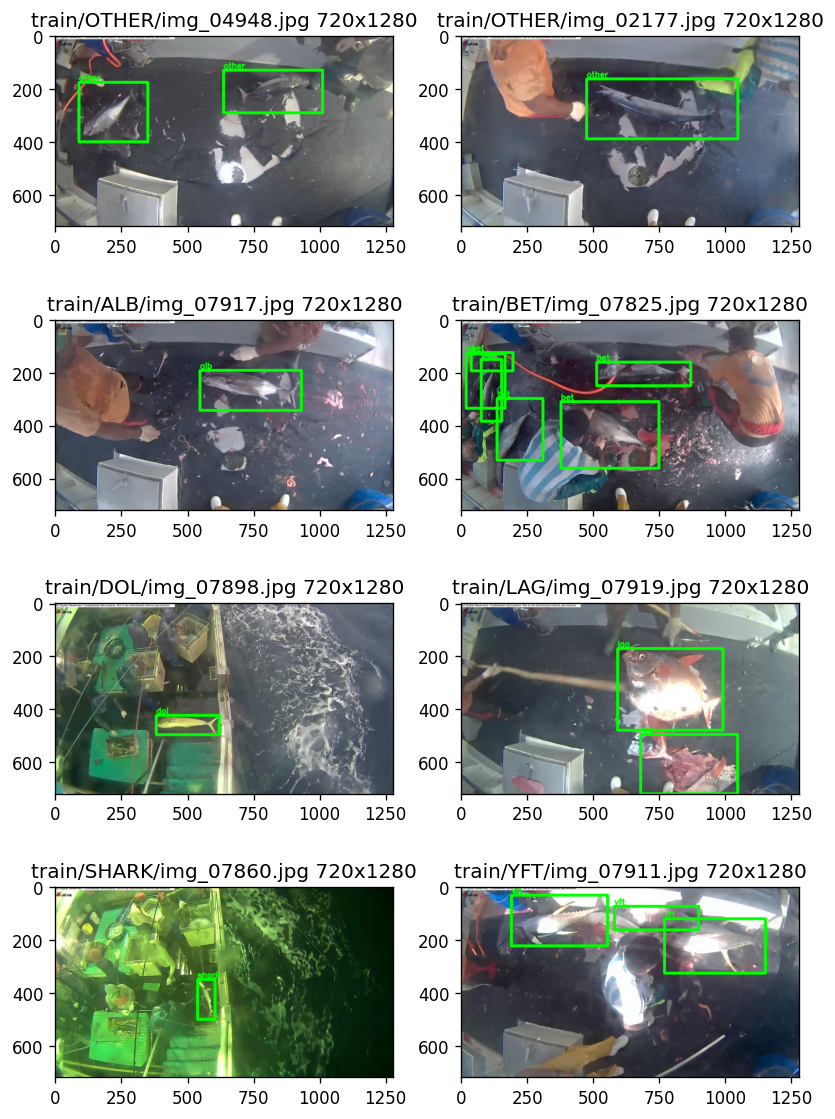

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8, 12), dpi=120)
boxes_ = [boxes['other'][3],boxes['other'][4],boxes['alb'][0],boxes['bet'][0],boxes['dol'][0],boxes['lag'][0],
         boxes['shark'][0], boxes['yft'][0]]

for i, box in enumerate(boxes_, 1):
    img = draw_boxes(box)
    subplot = fig.add_subplot(4, 2, i)
    subplot.set_title('{} {}x{}'.format(box['filename'], img.shape[0], img.shape[1]))
    plt.imshow(img);

### Распределение размеров разметки

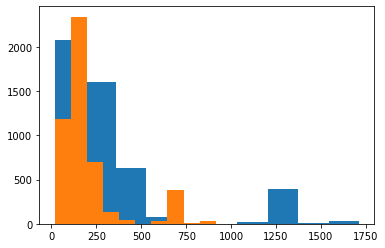

In [ ]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [19]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False
    
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 23, 37, 512)


# Сетка якорей (anchor grid)

In [20]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])
print(FEATURE_SHAPE)

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

# сетка якорей, размер определяется соотношением 
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

(23, 37)


In [21]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 13), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        label = fish_classes == rect['class']
                
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]
            
        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = np.array([*label, 1., dx, dy, dw, dh])

    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            
            label = np.empty(len(fish_classes))
            
            *label, digit, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(digit)
            label = softmax(label)

            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'label': np.argmax(_sigmoid(label)),
                                   'labels': label })
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles
    
    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)
    
    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

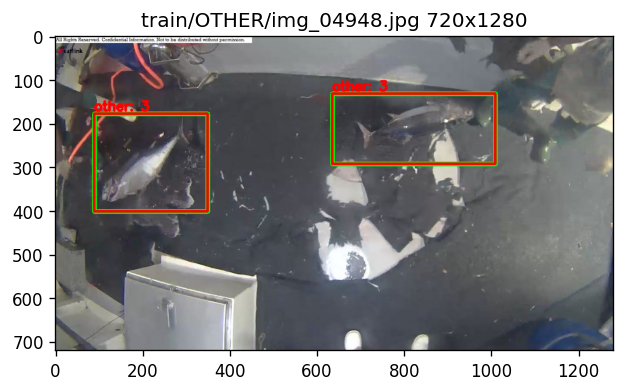

In [ ]:
annotation = boxes['other'][3]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.1)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

## Функция потерь

In [22]:
num_classes = len(fish_classes)

K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    
    conf_loss = K.binary_crossentropy(y_true[..., num_classes], 
                                      y_pred[..., num_classes],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., num_classes + 1:] - y_pred[..., num_classes + 1:])
    square_loss = 0.5 * K.square(y_true[..., num_classes + 1:] - y_pred[..., num_classes + 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)


def class_loss(y_tr, y_pr, alpha=0.25, gamma=2.0):
    
    y_true = y_tr[..., :num_classes]
    y_pred = y_pr[..., :num_classes]

    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=y_true, logits=y_pred
    )
    probs = tf.nn.softmax(y_pred)
    alpha = tf.where(tf.equal(y_true, 1.0), alpha, (1.0 - alpha))
    pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
    loss = alpha * tf.pow(1.0 - pt, gamma) * cross_entropy
    
    return tf.reduce_sum(loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    y_true = K.reshape(y_true, (batch_size, -1, num_classes + 5))
    y_pred = K.reshape(y_pred, (batch_size, -1, num_classes + 5))
    
    # TODO: добавьте функцию потерь для классификации детекции
    classification_loss = class_loss(y_true, y_pred)

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)

    # positive examples loss
    pos_class_loss = K.sum(classification_loss * y_true[..., num_classes], axis=-1)
    pos_conf_loss = K.sum(conf_loss * y_true[..., num_classes], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., num_classes], axis=-1)

    # negative examples loss
    anchors = K.shape(y_true)[1]

    num_pos = K.sum(y_true[..., num_classes], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., num_classes]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    classification_loss = pos_class_loss / (num_pos + 1e-32)
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
   
    return total_conf_loss + 0.5 * loc_loss + classification_loss

## Загрузка данных

In [23]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            yield np.array(X), np.array(y)

def train_generator(boxes, batch_size=32):
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            yield np.array(X), np.array(y)

def val_generator(boxes, batch_size=32):
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [24]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = tf.keras.layers.Conv2D(num_classes + 5,
                                kernel_size=(1, 1), 
                                activation='linear',
                                kernel_regularizer='l2')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 750, 1200, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 750, 1200, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 750, 1200, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 375, 600, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 375, 600, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 375, 600, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 187, 300, 128)     0   

## Обучение

⛏Разбиваем на трейн и валидацию

In [25]:
val_filename = []
for fish_cls in fish_classes:
  fish_num = int(len(boxes[fish_cls]) * 0.2)

  boxes1 = boxes[fish_cls][-fish_num:]
  for box in boxes1:
    val_filename.append(box['filename'])
  
boxes1 = sum(boxes.values(), [])
boxes_train = list(filter(lambda x: x['filename'] not in val_filename, boxes1))
boxes_val = list(filter(lambda x: x['filename'] in val_filename, boxes1))

In [26]:
lr =1e-5
BATCH_SIZE = 5
EPOCHS = 10

In [27]:
def lr_exp_decay(epoch, lr):
    k = 0.5
    #return lr * np.exp(-k*epoch)
    return lr / 2**epoch

optimizer = tf.keras.optimizers.Adam(learning_rate=lr, decay=1e-6)
model.compile(optimizer=optimizer, 
              loss=total_loss,
              metrics=[confidence_loss, class_loss, smooth_l1])


gen = data_generator(boxes, batch_size=BATCH_SIZE)
steps_per_epoch = sum(map(len, boxes.values()), 0) / BATCH_SIZE

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/fish/fishdetector_wh_val.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=True,
    mode='auto',
    save_freq=50)

In [ ]:
history = model.fit(
          train_generator(boxes_train, batch_size=BATCH_SIZE), 
          steps_per_epoch=len(boxes_train) / BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=val_generator(boxes_val, batch_size=BATCH_SIZE),
          validation_steps=len(boxes_val) / BATCH_SIZE,
          callbacks=[checkpoint]) #, tf.keras.callbacks.LearningRateScheduler(lr_exp_decay, verbose=1)])

Epoch 1/10
 49/605 [=>............................] - ETA: 5:57 - loss: 0.1503 - confidence_loss: 0.0072 - class_loss: 0.1224 - smooth_l1: 1.0626
Epoch 1: loss improved from inf to 0.14926, saving model to /content/drive/MyDrive/fish/fishdetector_wh_val.hdf5
 99/605 [===>..........................] - ETA: 5:34 - loss: 0.1460 - confidence_loss: 0.0072 - class_loss: 0.1230 - smooth_l1: 1.0659
Epoch 1: loss improved from 0.14926 to 0.14647, saving model to /content/drive/MyDrive/fish/fishdetector_wh_val.hdf5
149/605 [======>.......................] - ETA: 5:01 - loss: 0.1414 - confidence_loss: 0.0071 - class_loss: 0.1237 - smooth_l1: 1.0636
Epoch 1: loss improved from 0.14647 to 0.14128, saving model to /content/drive/MyDrive/fish/fishdetector_wh_val.hdf5
199/605 [========>.....................] - ETA: 4:29 - loss: 0.1434 - confidence_loss: 0.0072 - class_loss: 0.1242 - smooth_l1: 1.0627
Epoch 1: loss did not improve from 0.14128
249/605 [===========>..................] - ETA: 3:55 - loss

## Результат работы детектора

In [28]:
model.load_weights('/content/drive/MyDrive/fish/fishdetector_wh_val.hdf5')
#model = tf.keras.models.load_model('/content/drive/MyDrive/fish/fishdetector_wh.hdf5')

Продемонстрируем работу модели на тренировочных данных (зеленым обозначена исходная разметка и класс; красным - предсказанный моделью класс и область размещения):

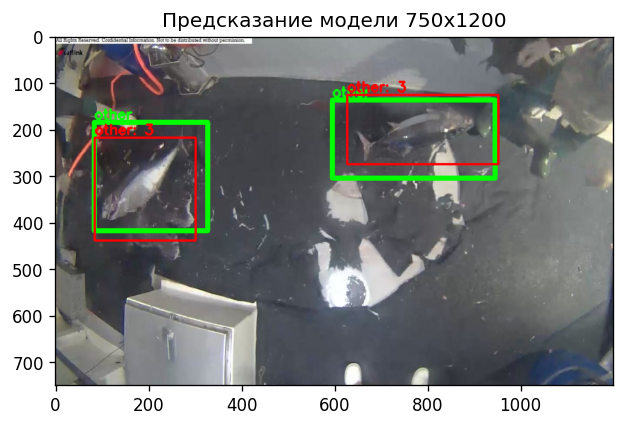

In [ ]:
annotation = boxes['other'][3]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.1)

decoded = non_max_suppression(decoded,
                              max_output_size=2,
                              iou_threshold=0.5)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

На данной фотографии две рыбы и две области, на деле модель более-менее справляется только с первой областью, погрешность для второй и следующих высокая, поэтому ограничимся только ею.

Ещё несколько примеров на тренировочных данных для разных классов:

In [ ]:
# {'filename': filename['filename']}
test_images = [boxes['alb'][1], boxes['alb'][3], boxes['yft'][1],
               boxes['yft'][7], boxes['other'][0], boxes['other'][1],
               boxes['bet'][1], boxes['bet'][6], boxes['shark'][3],
               boxes['shark'][6], boxes['dol'][0], boxes['dol'][1],
               boxes['lag'][0], boxes['lag'][8]
]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename['filename'])

    pred = model.predict(np.array([sample_img,]))
    decoded = decode_prediction(pred[0], conf_thr=0.003)
    decoded = non_max_suppression(decoded,
                                  max_output_size=1,
                                  iou_threshold=0.1)
    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes(filename, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание модели {}'.format(filename['filename'].split('/')[-1]));

Output hidden; open in https://colab.research.google.com to view.

## Визуализируем предсказание на тесте

In [29]:

with zipfile.ZipFile("/content/drive/MyDrive/fish/test_stg1.zip","r") as z:
    z.extractall(".")
import py7zr
with py7zr.SevenZipFile("/content/drive/MyDrive/fish/test_stg2.7z", mode='r') as z:
    z.extractall()


In [38]:
test_images = glob('test_stg1/*.jpg')[550:570]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)

    pred = model.predict(np.array([sample_img,]))
    decoded = decode_prediction(pred[0], conf_thr=0.002)
    decoded = non_max_suppression(decoded,
                                  max_output_size=1,
                                  iou_threshold=0.1)
    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename.split('/')[-1]));

Output hidden; open in https://colab.research.google.com to view.

## Готовим данные для сабмита

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0

In [30]:
fish_classes

array(['alb', 'yft', 'nof', 'other', 'bet', 'shark', 'dol', 'lag'],
      dtype=object)

In [31]:
import re
p = re.compile(r'_(\d+)')
CONF_THR = 0.003

def make_predictions() -> pd.DataFrame:
    df_submit = []

    images_list =glob('test_stg1/*.jpg')
    images_list = sorted(images_list, key = lambda s: int(p.search(s).group(1)))

    for file in tqdm(images_list):
        _, sample_img = load_img(file)
        
        pred = model.predict(np.array([sample_img,]))[0]
        decoded = decode_prediction(pred, conf_thr=CONF_THR)
        decoded = non_max_suppression(decoded,
                              max_output_size=1,
                              iou_threshold=0.5)
        
        row_predict = {}
        
        row_predict['image'] = re.search("img_\d+\.jpg", file)[0]
        #row_predict['conf'] = decoded[0]['conf']
        
        decoded = decoded[0]['labels']
        
        row_predict['ALB'] = decoded[0]
        row_predict['BET'] = decoded[4]
        row_predict['DOL'] = decoded[6]
        row_predict['LAG'] = decoded[7]
        row_predict['NoF'] = decoded[2] # фиксированная вероятность для класса 'No Fishes' из файла sample_submission
        row_predict['OTHER'] = decoded[3]
        row_predict['SHARK'] = decoded[5]
        row_predict['YFT'] = decoded[1]     

        df_submit.append(row_predict)

    images_list = glob('test_stg2/*.jpg')
    images_list = sorted(images_list, key = lambda s: int(p.search(s).group(1)))

    for file in tqdm(images_list):
        _, sample_img = load_img(file)
        
        pred = model.predict(np.array([sample_img,]))[0]
        decoded = decode_prediction(pred, conf_thr=CONF_THR)
        decoded = non_max_suppression(decoded,
                              max_output_size=1,
                              iou_threshold=0.5)
        
        row_predict = {}
        
        row_predict['image'] = 'test_stg2/' + re.search("image_\d+\.jpg", file)[0]
        #row_predict['conf'] = decoded[0]['conf']
        
        decoded = decoded[0]['labels']
        
        row_predict['ALB'] = decoded[0]
        row_predict['BET'] = decoded[4]
        row_predict['DOL'] = decoded[6]
        row_predict['LAG'] = decoded[7]
        row_predict['NoF'] = decoded[2] # фиксированная вероятность для класса 'No Fishes' из файла sample_submission
        row_predict['OTHER'] = decoded[3]
        row_predict['SHARK'] = decoded[5]
        row_predict['YFT'] = decoded[1]    
       
        df_submit.append(row_predict)

    return pd.DataFrame.from_dict(df_submit)

In [32]:
df_submit = make_predictions()
df_submit.to_csv("/content/drive/MyDrive/fish/submit_hw3_val.csv", index=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/12153 [00:00<?, ?it/s]

## Результат на kaggle

Ранее я загружал решение, рассчитанное на том же количестве эпох, но без валидации и разметки категории NoF (нет рыбы), можно видеть как разметка NoF улучшила результат.

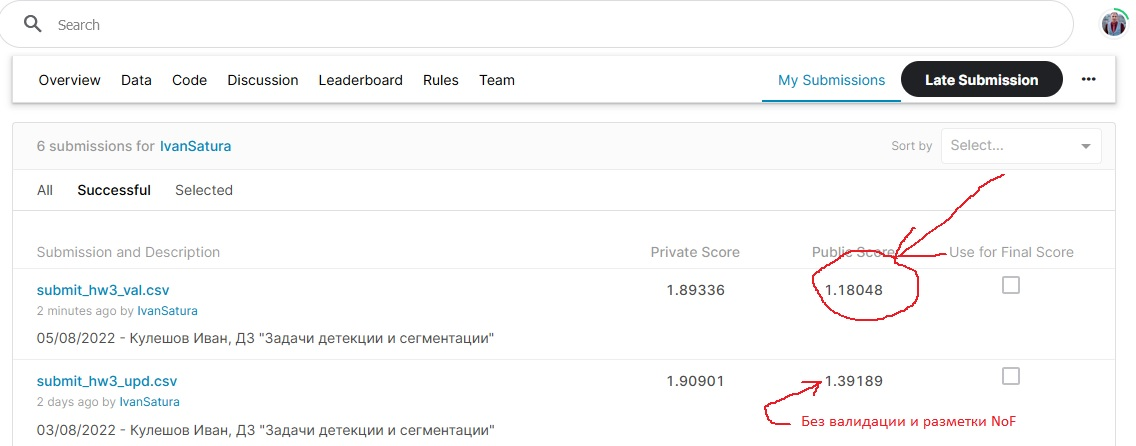